# Object Detection and Tracking using Canny Edge Detection and Kalman Filter

### DSP Project
### N D V Hareesh 214102310

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#set plot size for all plots
plt.rcParams["figure.figsize"] = (20,16)

#### Function for detection

In [7]:
def detect(frame,debugMode):
    # Convert frame from BGR to GRAY
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if (debugMode):
        cv2.imshow('gray', gray)

    # Edge detection using Canny function
    img_edges = cv2.Canny(gray,  50, 190, 3)
    if (debugMode):
        cv2.imshow('img_edges', img_edges)

    # Conversion of gray image to black and white image
    ret, img_thresh = cv2.threshold(img_edges, 254, 255,cv2.THRESH_BINARY)
    if (debugMode):
        cv2.imshow('img_thresh', img_thresh)

    # Find contours in the given frame
    contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Set the minimum & maximum radius of a detected ball
    min_radius= 2.8
    max_radius= 32

    centers=[]
    for c in contours:
        (x, y), radius = cv2.minEnclosingCircle(c)
        radius = int(radius)

        #Taking only the valid circles
        if (radius > min_radius) and (radius < max_radius):
            centers.append(np.array([[x], [y]]))
    cv2.imshow('contours', img_thresh)
    return centers

#### Initialization of variables used in Prediction and update functions

In [8]:
# Define sampling time
dt = 0.1
u_x=1
u_y=1
std_acc=1
x_std_meas=0.1
y_std_meas=0.1

# Define the  control input variables
u = np.matrix([[u_x],[u_y]])

# Intial State
x = np.matrix([[0], [0], [0], [0]])

# Define the State Transition Matrix A
A = np.matrix([[1, 0, dt, 0],
                    [0, 1, 0, dt],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

# Define the Control Input Matrix B
B = np.matrix([[(dt**2)/2, 0],
                    [0,(dt**2)/2],
                    [dt,0],
                    [0,dt]])

# Define Measurement Mapping Matrix
H = np.matrix([[1, 0, 0, 0],
                    [0, 1, 0, 0]])

#Initial Process Noise Covariance
Q = np.matrix([[(dt**4)/4, 0, (dt**3)/2, 0],
                    [0, (dt**4)/4, 0, (dt**3)/2],
                    [(dt**3)/2, 0, dt**2, 0],
                    [0, (dt**3)/2, 0, dt**2]]) * std_acc**2

#Initial Measurement Noise Covariance
R = np.matrix([[x_std_meas**2,0],
                   [0, y_std_meas**2]])

#Initial Covariance Matrix
P = np.eye(A.shape[1])



#### Function for Prediction 

In [9]:
def predict(x,P):
    
    # Update time state
    #x_k =Ax_(k-1) + Bu_(k-1)     
    x = np.dot(A, x) + np.dot(B, u)


    # Calculate error covariance
    # P= A*P*A' + Q               
    P = np.dot(np.dot(A, P), A.T) + Q
    return x[0:2],P,x

#### Function for update

In [10]:
def update(z,P,x):
    
    # S = H*P*H'+R
    S = np.dot(H, np.dot(P, H.T)) + R

    # Calculate the Kalman Gain
    # K = P * H'* inv(H*P*H'+R)
    K = np.dot(np.dot(P, H.T), np.linalg.inv(S))  

    x = np.round(x + np.dot(K, (z - np.dot(H, x))))   

    I = np.eye(H.shape[1])

    # Update error covariance matrix
    P = (I - (K * H)) * P   #Eq.(13)
    return x[0:2],x,P

#### Execution Block

In [19]:
import cv2


# Create opencv video capture object
VideoCap = cv2.VideoCapture('video_randomball.avi')

debugMode=1

while(True):
    # Read frame
    ret, frame = VideoCap.read()
    
    # Detect object
    centers = detect(frame,debugMode)

    # If centroids are detected then track them
    if (len(centers) > 0):

        # Draw the detected circle
        cv2.circle(frame, (int(centers[0][0]), int(centers[0][1])), 10, (0, 255, 0), 2)

        # Predict
        (x1, y1),P,x =  predict(x,P)
        # Draw a rectangle as the predicted object position
        cv2.rectangle(np.ascontiguousarray(frame), (int(x1 - 15), int(y1 - 15)), (int(x1+ 15), int(y1 + 15)), (255, 0, 0), 2)

        # Update
        (x2, y2),x,P = update(centers[0],P,x)

        # Draw a rectangle as the estimated object position
        cv2.rectangle(np.ascontiguousarray(frame), (int(x2 - 15), int(y2 - 15)), (int(x2 + 15), int(y2 + 15)), (0, 0, 255), 2)

        cv2.putText(frame, "Estimated Position of Ball", (int(x2 + 15), int(y2 + 10)), 0, 0.5, (0, 0, 255), 2)
        cv2.putText(frame, "Predicted Position of Ball", (int(x1 + 15), int(y1)), 0, 0.5, (255, 0, 0), 2)
        cv2.putText(frame, "Measured Position of Ball", (int(centers[0][0] + 15), int(centers[0][1] - 15)), 0, 0.5, (0,255,0), 2)

    cv2.imshow('Result Video', frame)
    
    
    if cv2.waitKey(2) & 0xFF == ord('q'):
        VideoCap.release()
        cv2.destroyAllWindows()
        break
    
        
    cv2.waitKey(1)

####################################################################################################################

#### Code for plotting Output Screenshots

Text(0.5, 1.0, 'Output Frame')

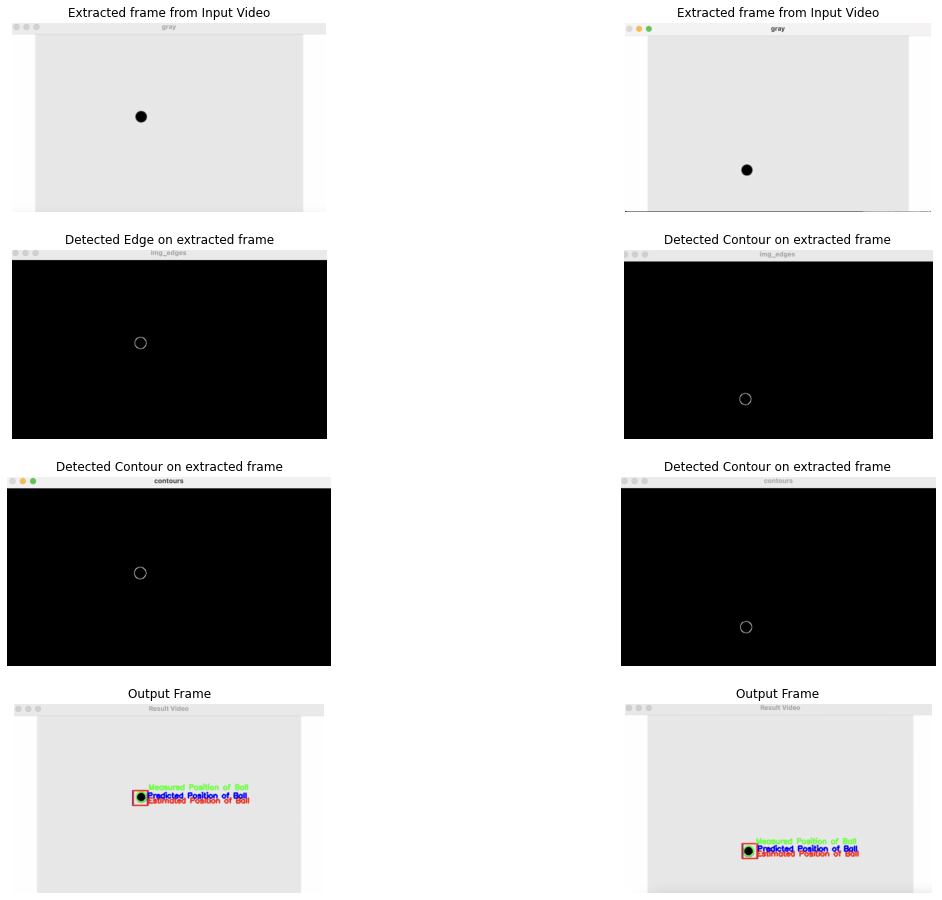

In [18]:
image_ip_frame1 = plt.imread('fig1.png')
plt.subplot(4, 2, 1)
plt.imshow(image_ip_frame1)
plt.axis('off')
plt.title('Extracted frame from Input Video')


plt.subplot(4, 2, 2)
image_ip_frame1 = plt.imread('fig5.png')
plt.imshow(image_ip_frame1)
plt.axis('off')
plt.title('Extracted frame from Input Video')

plt.subplot(4, 2, 3)
image_binary_frame1 = plt.imread('fig2.png')
plt.imshow(image_binary_frame1)
plt.axis('off')
plt.title('Detected Edge on extracted frame')

plt.subplot(4, 2, 4)
image_binary_frame1 = plt.imread('fig6.png')
plt.imshow(image_binary_frame1)
plt.axis('off')
plt.title('Detected Contour on extracted frame')

plt.subplot(4, 2, 5)
image_countours_frame1 = plt.imread('fig3.png')
plt.imshow(image_countours_frame1)
plt.axis('off')
plt.title('Detected Contour on extracted frame')


plt.subplot(4, 2, 6)
image_countours_frame1 = plt.imread('fig7.png')
plt.imshow(image_countours_frame1)
plt.axis('off')
plt.title('Detected Contour on extracted frame')

plt.subplot(4, 2, 7)
image_result_frame1 = plt.imread('fig4.png')
plt.imshow(image_result_frame1)
plt.axis('off')
plt.title('Output Frame')

plt.subplot(4, 2, 8)
image_countours_frame1 = plt.imread('fig8.png')
plt.imshow(image_countours_frame1)
plt.axis('off')
plt.title('Output Frame')

N